# PROTOTYPE OF FINAL PROJECT

In [1]:
#IMPORTS

import pandas as pd
import datetime
import seaborn as sns
import requests
import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
#GETTING CURRENCY RATES

def currency_converter():

    APIkey = "j4YVbY4DsPe2bRdqchwWzvccCljEhg2EhlPyfrEN"
    url = f"https://api.freecurrencyapi.com/v1/latest?apikey={APIkey}"
    response = requests.get(url).json()
    df = pd.DataFrame(response['data'], index=[0])
    return df

currency_converter()

,AUD,BGN,BRL,CAD,CHF,CNY,CZK,DKK,EUR,GBP,...,PHP,PLN,RON,RUB,SEK,SGD,THB,TRY,USD,ZAR
0,1.493637,1.867291,5.235649,1.365095,0.942015,6.996148,23.238091,7.106238,0.955433,0.824367,...,55.881227,4.481577,4.695386,60.551458,10.415155,1.358734,35.090356,18.632194,1,17.331527


In [3]:
#GETTING FEAR GRID VALUES

def fgindex() -> pd.DataFrame:
    """returns a dataframe of fear and greed index with columns:
    [value],[value_classification],[timestamp],[time_until_update] """

    url = 'https://api.alternative.me/fng/'
    params = {'limit':100000,'date_format':'world'}
    response = requests.get(url,params).json()
    fg = pd.DataFrame(response['data'])
    return fg

fgindex()

,value,value_classification,timestamp,time_until_update
0,29,Fear,07-12-2022,-1670319471
1,25,Extreme Fear,06-12-2022,NaN
2,26,Fear,05-12-2022,NaN
3,26,Fear,04-12-2022,NaN
4,27,Fear,03-12-2022,NaN
...,...,...,...,...
1763,11,Extreme Fear,05-02-2018,NaN
1764,24,Extreme Fear,04-02-2018,NaN
1765,40,Fear,03-02-2018,NaN
1766,15,Extreme Fear,02-02-2018,NaN


In [4]:
! pip install Historic-Crypto
from Historic_Crypto import HistoricalData

In [5]:
#GETTING CLOSING PRICES OF CRYPTO CURRENCY

crypto = 'BTC'

def prices(crypto)-> pd.DataFrame:

    today = datetime.datetime.today().strftime('%Y-%m-%d')
    crypto_df = HistoricalData(f'{crypto}-USD',86400,'2018-01-31-00-00',f"{today}-00-00",verbose = False).retrieve_data()
    return crypto_df

prices(crypto)

Provisional Start: 2018-01-31T00:00:00
Provisional End: 2018-11-27T00:00:00
Provisional Start: 2018-11-27T00:00:00
Provisional End: 2019-09-23T00:00:00
Provisional Start: 2019-09-23T00:00:00
Provisional End: 2020-07-19T00:00:00
Provisional Start: 2020-07-19T00:00:00
Provisional End: 2021-05-15T00:00:00
Provisional Start: 2021-05-15T00:00:00
Provisional End: 2022-03-11T00:00:00
Provisional Start: 2022-03-11T00:00:00
Provisional End: 2023-01-05T00:00:00


,low,high,open,close,volume
time,,,,,
2018-02-01,8400.00,10166.25,10099.99,9014.23,38171.970034
2018-02-02,7540.00,9090.08,9014.22,8787.52,52039.268077
2018-02-03,8115.48,9499.00,8787.52,9240.00,23700.985090
2018-02-04,7859.00,9350.00,9227.80,8167.91,24062.181957
2018-02-05,6425.75,8349.16,8167.90,6905.19,59578.698221
...,...,...,...,...,...
2022-12-03,16863.58,17158.42,17094.25,16888.53,14081.450672
2022-12-04,16882.86,17199.99,16889.17,17108.90,16961.108288
2022-12-05,16865.22,17424.59,17108.90,16966.05,33618.451090


In [6]:
def data_cleaning(crypto = 'BTC'):
    '''The function returns a dataframe containing:
    price: the historical crypto price
    index: the Grid/fear index value
    '''
    #cleaning the price data

    BTC_USD = prices(crypto)
    BTC_USD= BTC_USD['close']

    #cleaning the sentiment data
    sentiment_data = fgindex()
    sentiment_data['timestamp'] = pd.to_datetime(sentiment_data['timestamp'])
    sentiment_data['value'] = sentiment_data['value'].astype('float')
    fg= pd.DataFrame(sentiment_data[['value', 'timestamp']])
    fg.set_index('timestamp', inplace=True)


    #merging the price and sentiment data
    df = fg.join(BTC_USD)

    #cleaning the merged dataframe
    df.dropna(inplace=True)
    df.rename(columns = {'close': 'price', 'value': 'index'}, inplace = True)

    return df

df = data_cleaning()

Provisional Start: 2018-01-31T00:00:00
Provisional End: 2018-11-27T00:00:00
Provisional Start: 2018-11-27T00:00:00
Provisional End: 2019-09-23T00:00:00
Provisional Start: 2019-09-23T00:00:00
Provisional End: 2020-07-19T00:00:00
Provisional Start: 2020-07-19T00:00:00
Provisional End: 2021-05-15T00:00:00
Provisional Start: 2021-05-15T00:00:00
Provisional End: 2022-03-11T00:00:00
Provisional Start: 2022-03-11T00:00:00
Provisional End: 2023-01-05T00:00:00


In [113]:
df.head()

,index,price
timestamp,,
2022-07-12,29.0,19303.65
2022-06-12,25.0,26555.20
2022-05-12,26.0,28941.95
2022-04-12,26.0,40086.23
2022-03-12,27.0,38813.02


In [116]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
import numpy as np

def window_data(df, window, feature__1_col_number, feature__2_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        feature_1 = df.iloc[i:(i + window), feature__1_col_number]
        feature_2 = df.iloc[i:(i + window), feature__2_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append([feature_1, feature_2])
        #X.append(feature_2)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [8]:

# Predict Closing Prices using a 10 day window of fear and greed index values and a target of the 11th day closing price
# Try a window size anywhere from 1 to 10 and see how the model performance changes
window_size = 10

# Column index 1 is the `Close` column
feature_1_column = 0
feature_2_column = 1
target_column = 1
X, y = window_data(df, window_size, feature_1_column, feature_2_column, target_column)


In [9]:
# Use 70% of the data for training and the remainder for testing

# x split
split = int(.7 * len(X))
X_train = X[:split - 1]
X_test = X[split:]

# y split
y_train = y[:split - 1]
y_test = y[split:]

In [10]:
df.dtypes

index    float64
price    float64
dtype: object

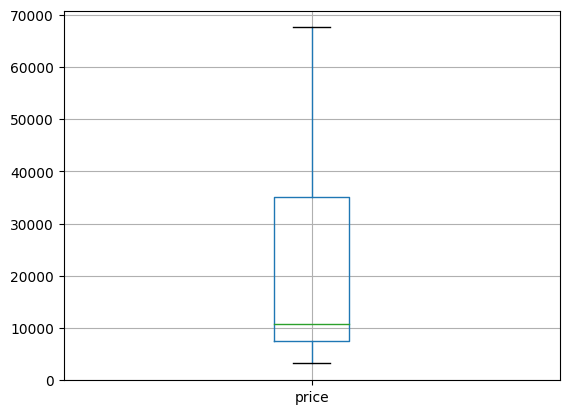

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

boxplot = df.boxplot(column=['price'])


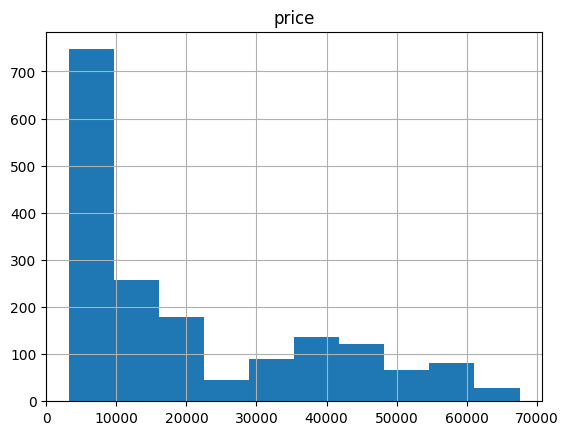

In [12]:
histogram = df.hist(column=['price'])
plt.show()

In [13]:
# Use MinMaxScaler to scale the data between 0 and 1
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y_train)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [14]:
X_train.shape

(1218, 10)

In [15]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [16]:
X_train.shape

(1218, 10, 1)

In [18]:
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 MB 3.0 MB/s eta 0:00:0000:0100:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 6.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 3.9 MB/s eta 0:00:0000:0100:01
  Using cached absl_py-1.3.0-py3-none-any.whl (124 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached tensorflow_io_gcs_filesystem-0.28.0-cp310-cp310-macosx_10_14_x86_64.whl (1.6 MB)
  Using cached protobuf-3.19.6-py2.py3-none-any.whl (162 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 3.3 MB/s eta 0:00:0000:0100:01
  Using cached typing_extensions-4.4.0-py3-none-any.whl (26 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached libclang-14.0.6-py2.py3-none-macosx_10_9_x86_64.whl (13.2 MB)
  Using cached h5py-3.7.0-cp310-cp310-macosx_10_9_x86_64.whl (3.2 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4

In [92]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics


def init_model(X_train, y_train):
    
    # $CHALLENGIFY_BEGIN    
    
    
    # 1 - RNN architecture
    # ======================    
    model = models.Sequential()

    ## 1.1 - Recurrent Layer
    model.add(layers.LSTM(64, 
                          activation='tanh', 
                          return_sequences = False,
                          recurrent_dropout = 0.2))
    #model.add(layers.LSTM(units=64, return_sequences=True, recurrent_dropout = 0.2))
    #model.add(layers.LSTM(units=64, return_sequences=False, recurrent_dropout = 0.2))
    ## 1.2 - Predictive Dense Layers
    output_length = y_train.shape[1]
    model.add(layers.Dense(output_length, activation='linear'))


    
    return model
    # $CHALLENGIFY_END

In [112]:
y_train.shape

(1211, 1)

In [70]:
def compile_model(model, optimizer_name):
    # $CHALLENGIFY_BEGIN
    model.compile(loss = 'mse',
                  optimizer = optimizer_name,
                  metrics = ['mae'])
    return model

In [58]:
model = init_model(X_train, y_train)


In [59]:
def plot_history(history):
    
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    # --- LOSS: MSE --- 
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('MSE')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- METRICS:MAE ---
    
    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])
    ax[1].set_title('MAE')
    ax[1].set_ylabel('MAE')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
               
    return ax

In [60]:
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from typing import Dict, List, Tuple, Sequence
def fit_model(model: tf.keras.Model, verbose=1) -> Tuple[tf.keras.Model, dict]:

    # $CHALLENGIFY_BEGIN
    es = EarlyStopping(monitor = "val_loss",
                      patience = 30,
                      mode = "min",
                      restore_best_weights = True)


    history = model.fit(X_train, y_train,
                        validation_split = 0.3,
                        shuffle = False,
                        batch_size = 32,
                        epochs = 50,
                        callbacks = [es],
                        verbose = verbose)

    return model, history
    # $CHALLENGIFY_END

In [61]:
# 1 - Initialising the RNN model
# ====================================

model = init_model(X_train, y_train)
#model.summary()

# 2 - Training
# ====================================
model, history = fit_model(model)

Epoch 1/50
27/27 [==============================] - 12s 71ms/step - loss: 0.2840 - mae: 0.4341 - val_loss: 0.1870 - val_mae: 0.4088
Epoch 2/50
27/27 [==============================] - 1s 30ms/step - loss: 0.2641 - mae: 0.4227 - val_loss: 0.4164 - val_mae: 0.6406
Epoch 3/50
27/27 [==============================] - 1s 31ms/step - loss: 0.3872 - mae: 0.5308 - val_loss: 0.6771 - val_mae: 0.8191
Epoch 4/50
27/27 [==============================] - 1s 30ms/step - loss: 0.2908 - mae: 0.4713 - val_loss: 0.6300 - val_mae: 0.7899
Epoch 5/50
27/27 [==============================] - 1s 32ms/step - loss: 0.2734 - mae: 0.4540 - val_loss: 0.6812 - val_mae: 0.8217
Epoch 6/50
27/27 [==============================] - 1s 37ms/step - loss: 0.2732 - mae: 0.4540 - val_loss: 0.6840 - val_mae: 0.8235
Epoch 7/50
27/27 [==============================] - 1s 33ms/step - loss: 0.2733 - mae: 0.4543 - val_loss: 0.6818 - val_mae: 0.8221
Epoch 8/50
27/27 [==============================] - 1s 32ms/step - loss: 0.2733 - 

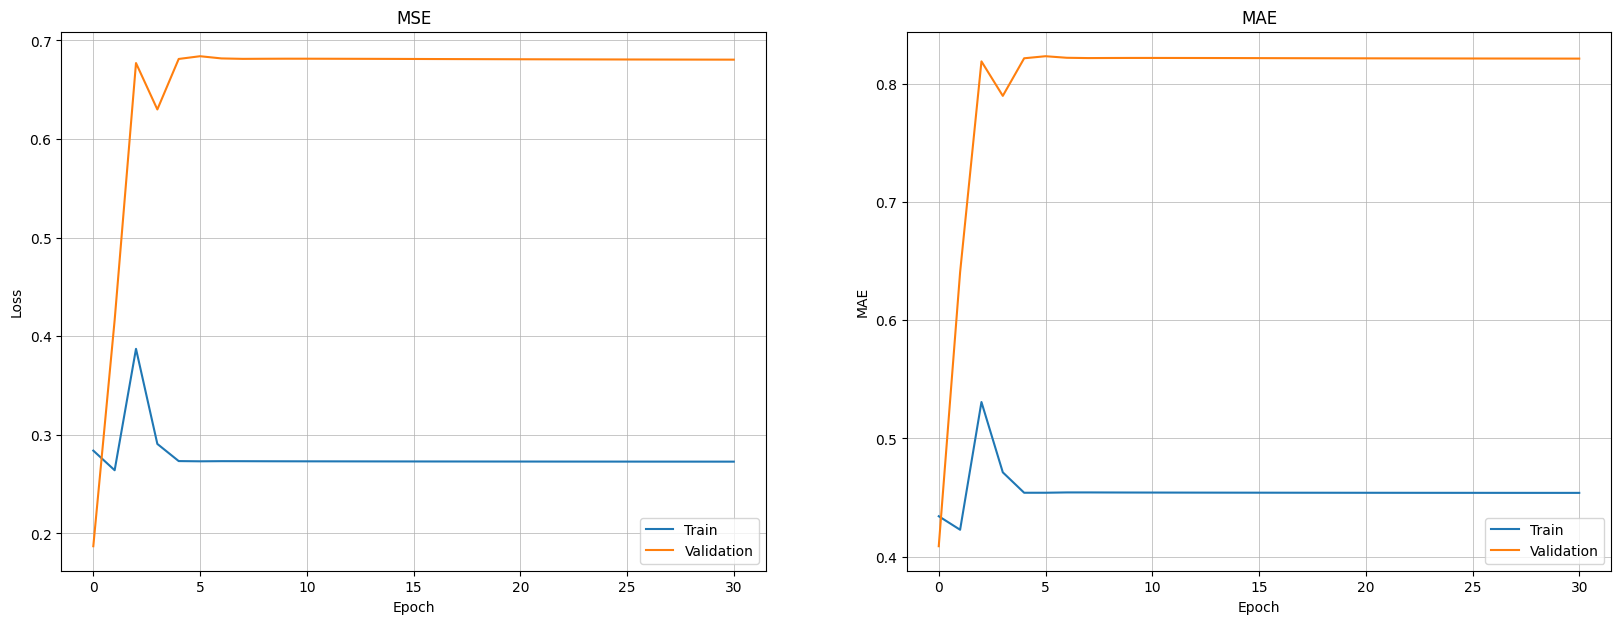

In [62]:
plot_history(history);
plt.show()

In [37]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 10, 64)            16896     
                                                                 
 dense_6 (Dense)             (None, 10, 1)             65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [63]:
from sklearn.model_selection import cross_val_score, GridSearchCV

In [ ]:
grid_search = GridSearchCV(
    pipe,
    param_grid = {
        # We can access ANY component of the pipeline! NOTE: those are DOUBLE underscores ;
        'imputer__n_neighbors' : [2, 5, 10, 15, 20]
    },
    cv = 5,
    scoring = 'recall'
)

In [64]:
dir(model)

['_SCALAR_UPRANKING_ON',
 '_TF_MODULE_IGNORED_PROPERTIES',
 '__annotations__',
 '__call__',
 '__class__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_activity_regularizer',
 '_add_trackable',
 '_add_trackable_child',
 '_add_variable_with_custom_getter',
 '_assert_compile_was_called',
 '_assert_weights_created',
 '_auto_config',
 '_auto_get_config',
 '_auto_track_sub_layers',
 '_autocast',
 '_autographed_call',
 '_base_model_initialized',
 '_build_graph_network_for_inferred_shape',
 '_build_input_shape',
 '_call_spec',
 '_callable_losses',
 '_captured_weight_regularizer',
 '_cast_single_input',
 '_check_call_args',

In [137]:
def plot_loss_mae(history):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,4))
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.set_title('Model loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylim(ymin=0, ymax=1)
    ax1.legend(['Train', 'Validation'], loc='best')
    ax1.grid(axis="x",linewidth=0.5)
    ax1.grid(axis="y",linewidth=0.5)
    ax2.plot(history.history['mae'])
    ax2.plot(history.history['val_mae'])
    ax2.set_title('MAE')
    ax2.set_ylabel('MAE')
    ax2.set_xlabel('Epoch')
    ax2.set_ylim(ymin=0, ymax=1)
    ax2.legend(['Train', 'Validation'], loc='best')
    ax2.grid(axis="x",linewidth=0.5)
    ax2.grid(axis="y",linewidth=0.5)
    plt.show()

17/17 [==============================] - 0s 14ms/step - loss: 0.6622 - mae: 0.7997
MAE with a learning rate of 0.0001 --> 0.7997


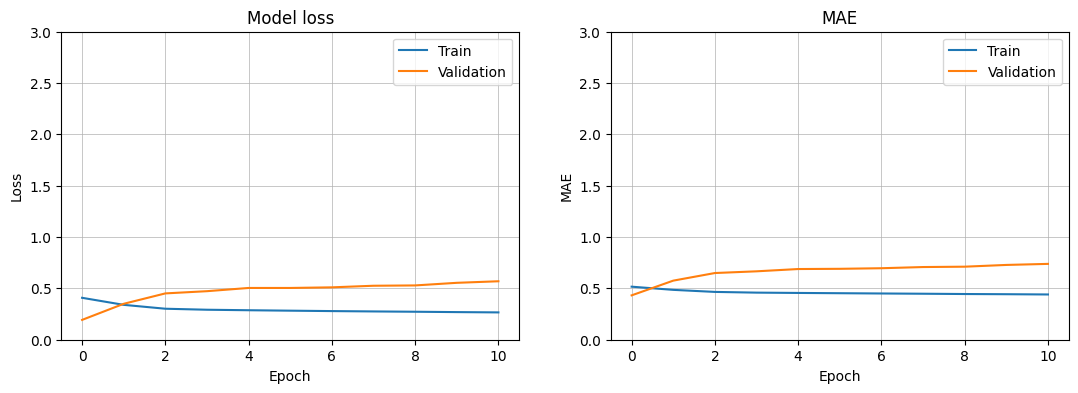

17/17 [==============================] - 0s 14ms/step - loss: 0.7209 - mae: 0.8443
MAE with a learning rate of 0.001 --> 0.8443


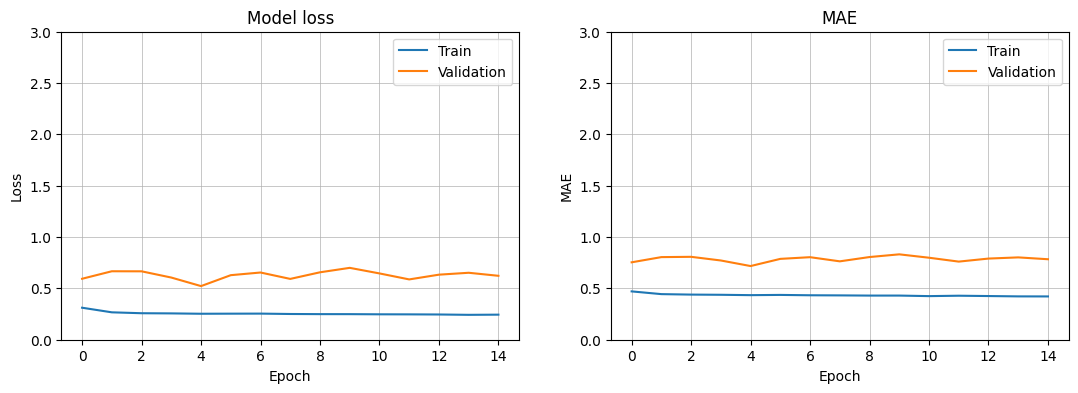

17/17 [==============================] - 0s 11ms/step - loss: 0.7197 - mae: 0.8453
MAE with a learning rate of 0.01 --> 0.8453


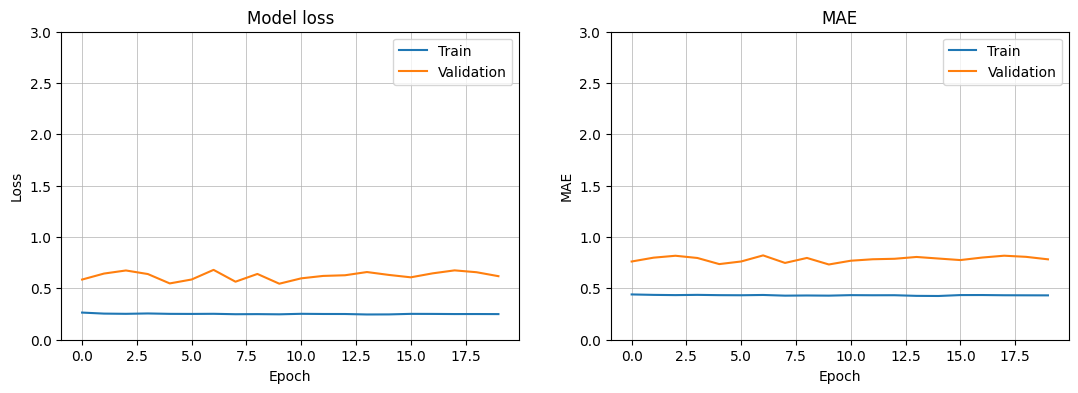

17/17 [==============================] - 0s 24ms/step - loss: 0.3727 - mae: 0.6060
MAE with a learning rate of 0.1 --> 0.6060


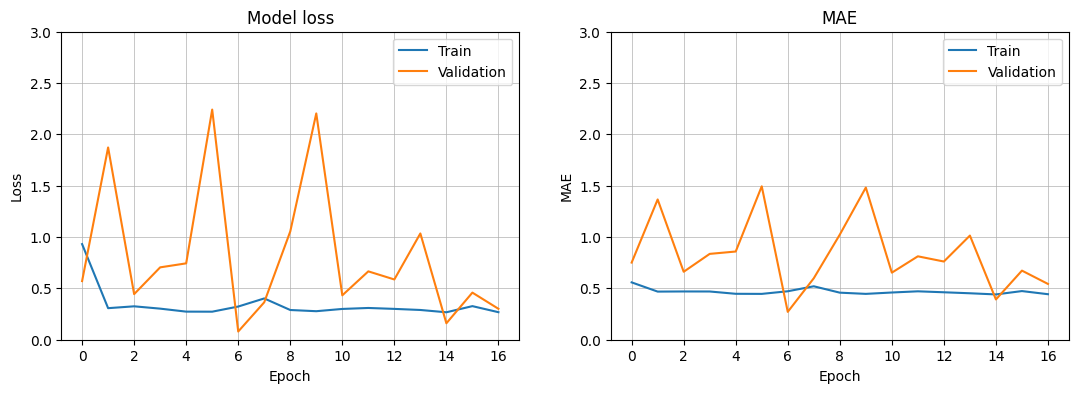

17/17 [==============================] - 0s 12ms/step - loss: 1.3032 - mae: 1.1341
MAE with a learning rate of 1 --> 1.1341


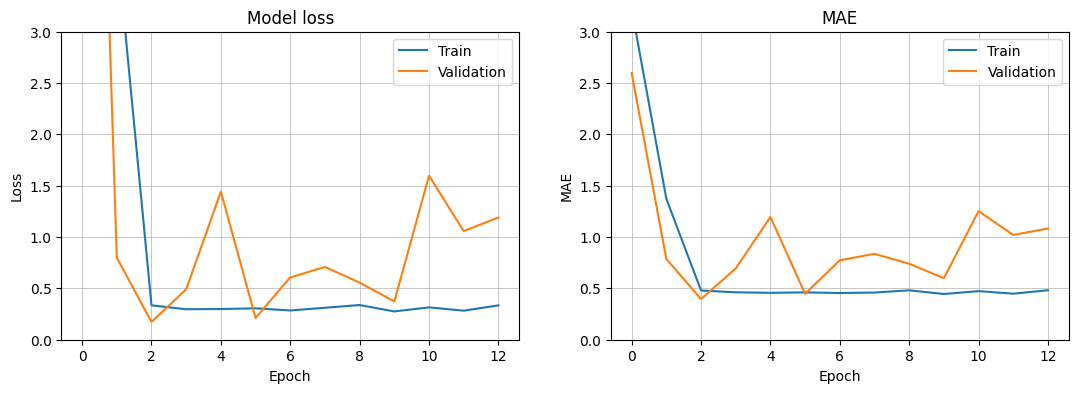

17/17 [==============================] - 0s 17ms/step - loss: 0.3493 - mae: 0.5643
MAE with a learning rate of 2 --> 0.5643


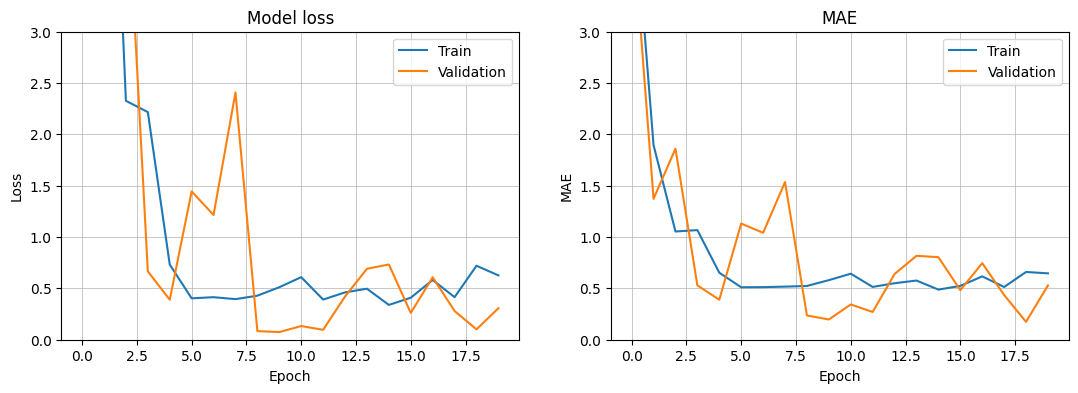

In [83]:
learning_rates = [0.0001, 0.001, 0.01, 0.1, 1, 2]
results = []
for learning_rate in learning_rates:
    # $CHALLENGIFY_BEGIN
    # 1. Instantiating the Adam optimizer with a specific learning_rate
    adam = optimizers.Adam(learning_rate = learning_rate)
    # 2. Initializing the model
    model = init_model(X_train, y_train)
    # 3. Compiling the model with the custom Adam optimizer
    model = compile_model(model, adam)
    # 4. Training the neural net
    es = EarlyStopping(patience = 10)
    history = model.fit(X_train,
                        y_train,
                        validation_split = 0.3,
                        shuffle = True,
                        batch_size=16,
                        epochs = 1_000,
                        callbacks = [es],
                        verbose = 0)
    # 5. Plot the history and evaluate the model
    res = model.evaluate(X_test, y_test)[1]
    results.append(res)
    print(f'MAE with a learning rate of {learning_rate} --> {res:.4f}')
    plot_loss_mae(history)

In [97]:
best_learning_rate = 0.1

17/17 [==============================] - 0s 16ms/step - loss: 0.6608 - mae: 0.8098
MAE with the scaler: RobustScaler() --> 0.8098


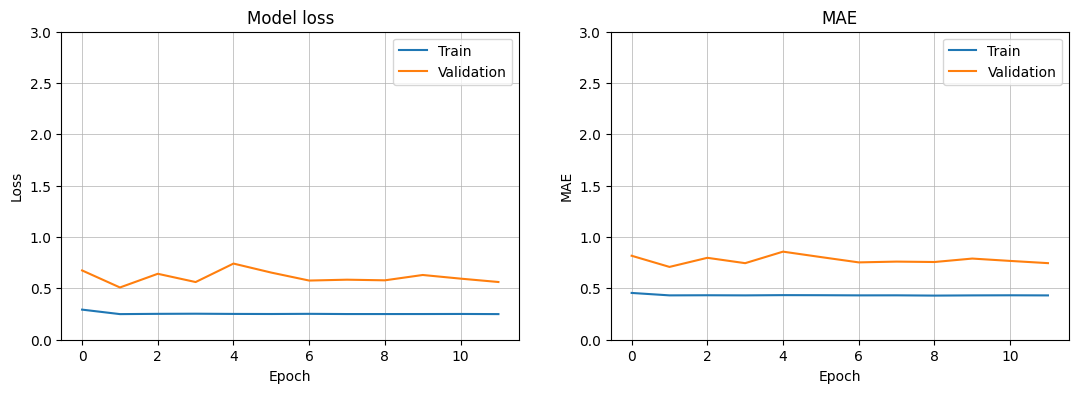

17/17 [==============================] - 0s 18ms/step - loss: 0.1687 - mae: 0.4089
MAE with the scaler: MinMaxScaler() --> 0.4089


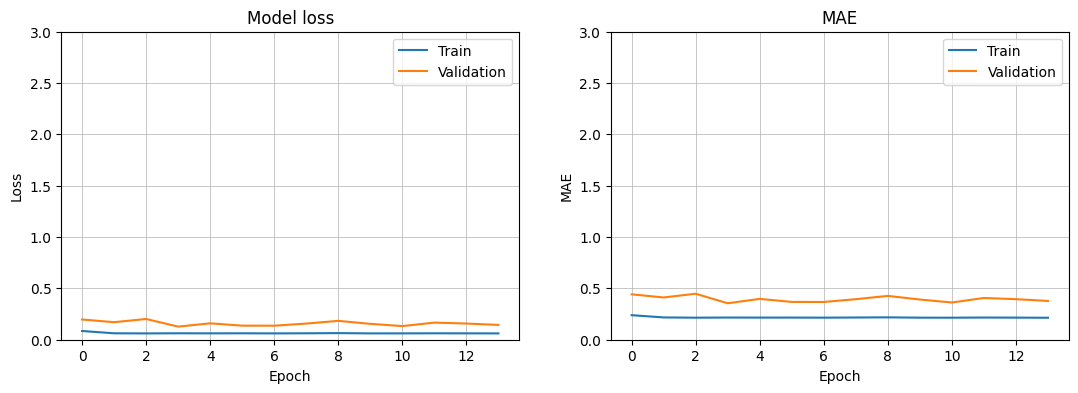

17/17 [==============================] - 0s 11ms/step - loss: 2.3513 - mae: 1.5281
MAE with the scaler: StandardScaler() --> 1.5281


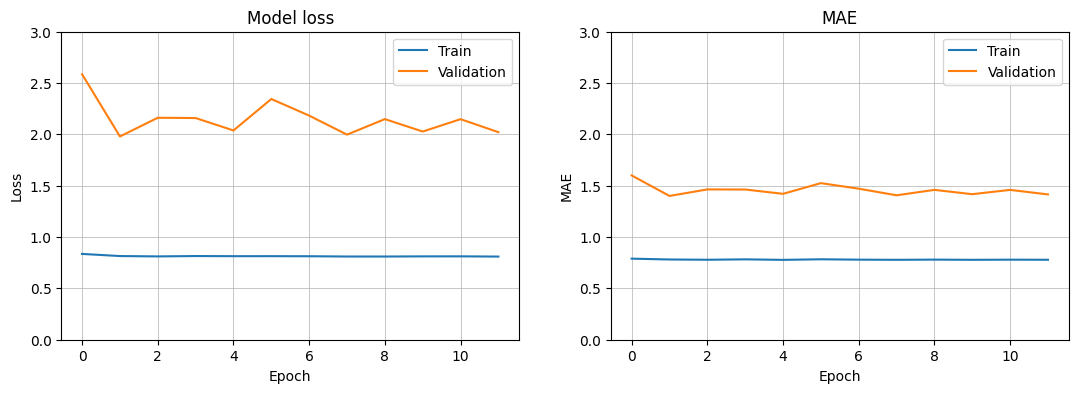

In [87]:
from sklearn.preprocessing import RobustScaler, StandardScaler
results = []
robust_scaler = RobustScaler()
minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()
scalers_list = [robust_scaler, minmax_scaler, standard_scaler]

for scaler in scalers_list:
    # $CHALLENGIFY_BEGIN
    #getting the fresh data
    # x split
    split = int(.7 * len(X))
    X_train = X[:split - 1]
    X_test = X[split:]

    # y split
    y_train = y[:split - 1]
    y_test = y[split:]
    #trying different scalers:
    scaler = scaler
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    scaler.fit(y_train)
    y_train = scaler.transform(y_train)
    y_test = scaler.transform(y_test)
    # Reshape the features for the model
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    # 1. Instantiating the Adam optimizer with a specific learning_rate
    adam = optimizers.Adam(learning_rate = 0.02)
    # 2. Initializing the model
    model = init_model(X_train, y_train)
    # 3. Compiling the model with the custom Adam optimizer
    model = compile_model(model, adam)
    # 4. Training the neural net
    es = EarlyStopping(patience = 10)
    history = model.fit(X_train,
                        y_train,
                        validation_split = 0.3,
                        shuffle = True,
                        batch_size=16,
                        epochs = 1_000,
                        callbacks = [es],
                        verbose = 0)
    # 5. Plot the history and evaluate the model
    res = model.evaluate(X_test, y_test)[1]
    results.append(res)
    print(f'MAE with the scaler: {scaler} --> {res:.4f}')
    plot_loss_mae(history)

In [98]:
best_scaler = minmax_scaler

17/17 [==============================] - 0s 5ms/step - loss: 0.7218 - mae: 0.8466
MAE with the scaler: RobustScaler() --> 0.8466


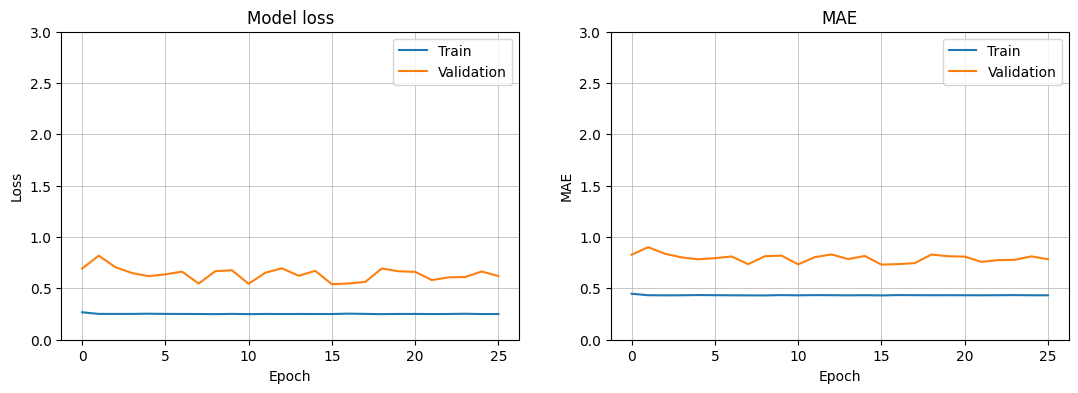

17/17 [==============================] - 0s 6ms/step - loss: 0.1683 - mae: 0.4088
MAE with the scaler: MinMaxScaler() --> 0.4088


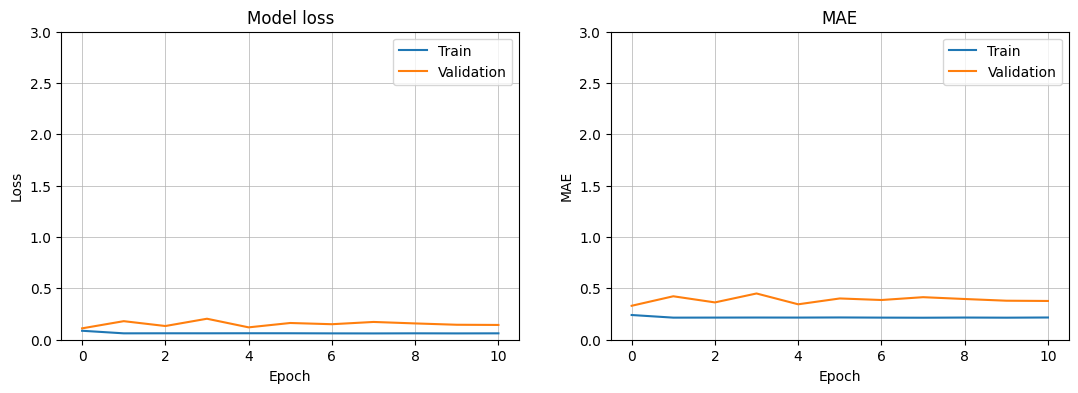

17/17 [==============================] - 0s 5ms/step - loss: 2.8735 - mae: 1.6039
MAE with the scaler: StandardScaler() --> 1.6039


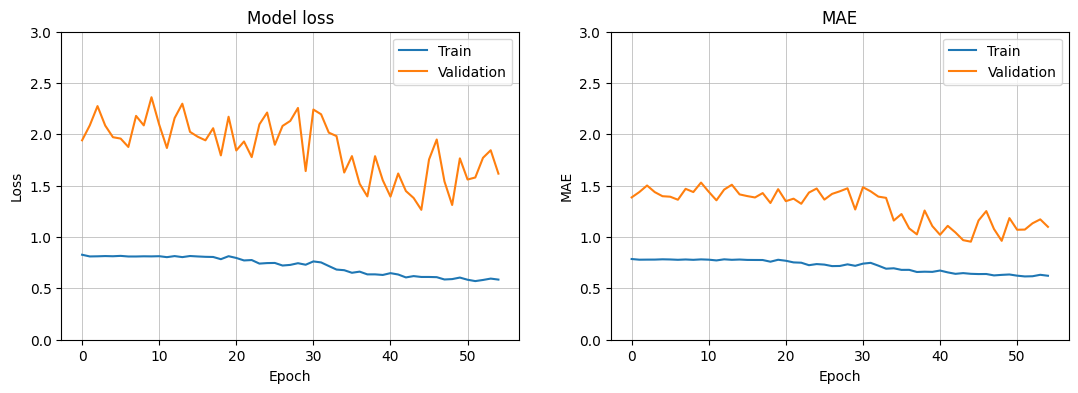

In [91]:
from sklearn.preprocessing import RobustScaler, StandardScaler
results = []
robust_scaler = RobustScaler()
minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()
scalers_list = [robust_scaler, minmax_scaler, standard_scaler]

for scaler in scalers_list:
    # $CHALLENGIFY_BEGIN
    #getting the fresh data
    # x split
    split = int(.7 * len(X))
    X_train = X[:split - 1]
    X_test = X[split:]

    # y split
    y_train = y[:split - 1]
    y_test = y[split:]
    #trying different scalers:
    scaler = scaler
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    scaler.fit(y_train)
    y_train = scaler.transform(y_train)
    y_test = scaler.transform(y_test)
    # Reshape the features for the model
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    # 1. Instantiating the Adam optimizer with a specific learning_rate
    adam = optimizers.Adam(learning_rate = 0.02)
    # 2. Initializing the model
    model = init_model(X_train, y_train)
    # 3. Compiling the model with the custom Adam optimizer
    model = compile_model(model, adam)
    # 4. Training the neural net
    es = EarlyStopping(patience = 10)
    history = model.fit(X_train,
                        y_train,
                        validation_split = 0.3,
                        shuffle = True,
                        batch_size=16,
                        epochs = 1_000,
                        callbacks = [es],
                        verbose = 0)
    # 5. Plot the history and evaluate the model
    res = model.evaluate(X_test, y_test)[1]
    results.append(res)
    print(f'MAE with the scaler: {scaler} --> {res:.4f}')
    plot_loss_mae(history)

17/17 [==============================] - 0s 4ms/step - loss: 0.4054 - mae: 0.6330
MAE with window size 5 --> 0.6330


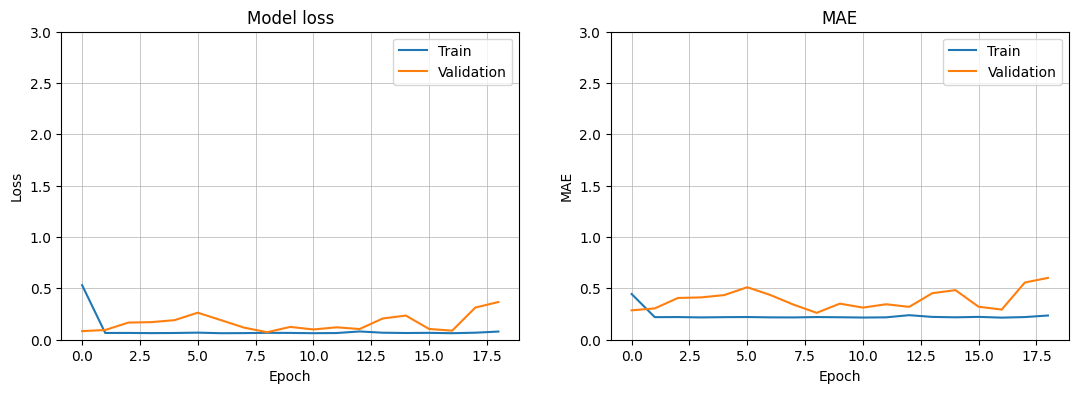

17/17 [==============================] - 0s 14ms/step - loss: 0.1780 - mae: 0.4203
MAE with window size 10 --> 0.4203


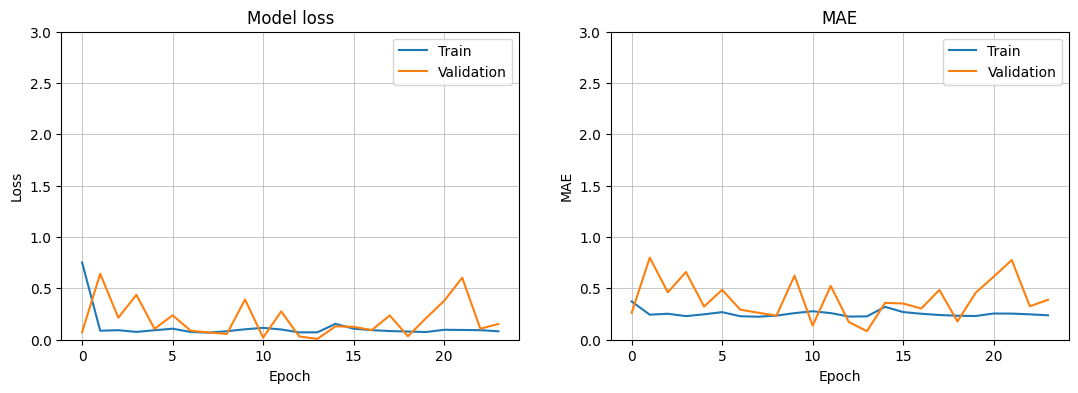

17/17 [==============================] - 0s 10ms/step - loss: 0.1825 - mae: 0.4258
MAE with window size 20 --> 0.4258


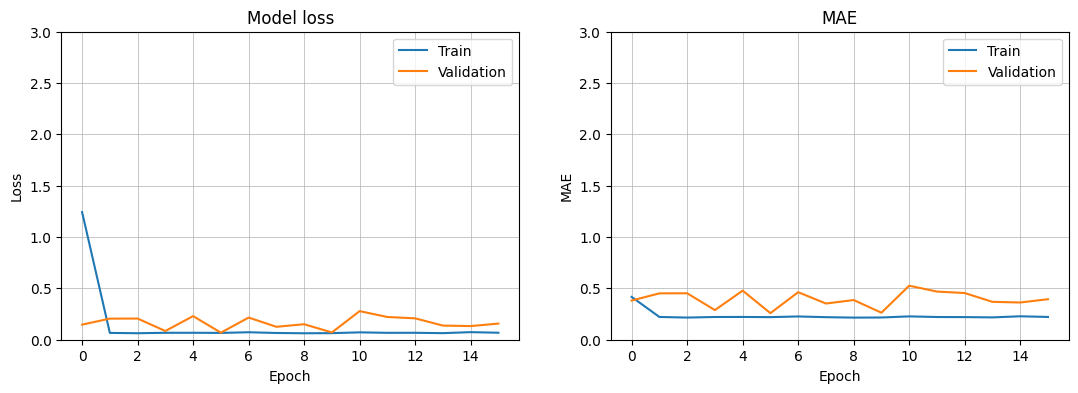

17/17 [==============================] - 0s 18ms/step - loss: 0.2236 - mae: 0.4715
MAE with window size 30 --> 0.4715


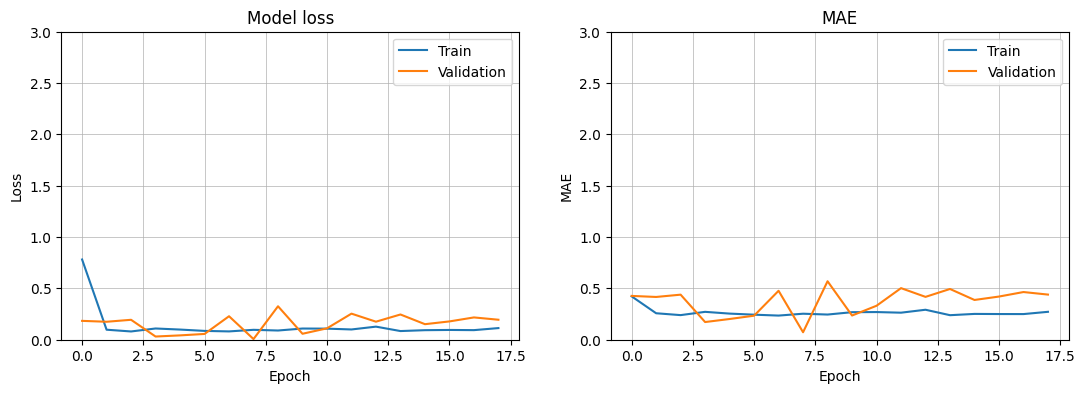

17/17 [==============================] - 0s 17ms/step - loss: 0.0680 - mae: 0.2573
MAE with window size 40 --> 0.2573


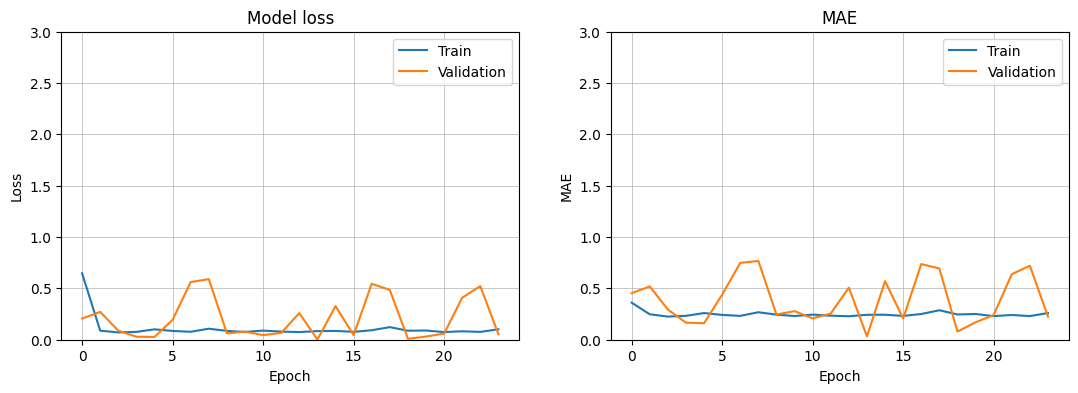

16/16 [==============================] - 0s 29ms/step - loss: 0.1400 - mae: 0.3723
MAE with window size 50 --> 0.3723


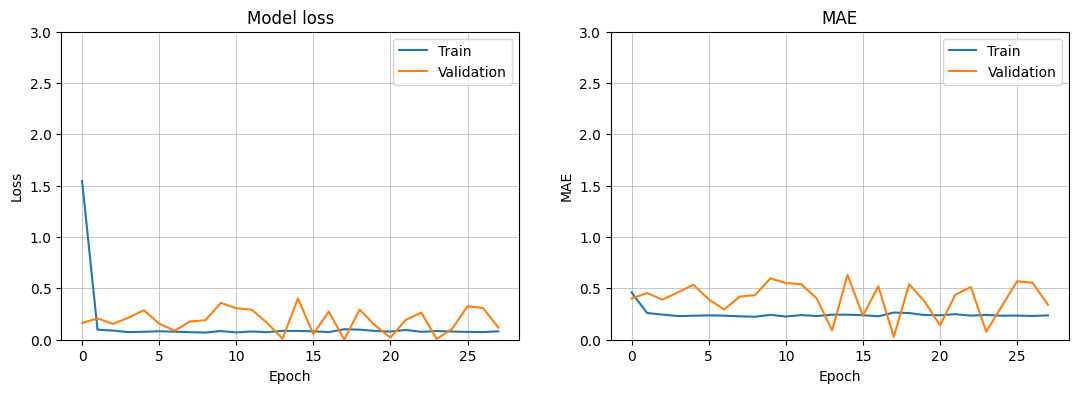

In [96]:
window_sizes = [5, 10, 20, 30, 40, 50]


for window_size in window_sizes:
    # $CHALLENGIFY_BEGIN
    #getting the fresh data
    # x split
    X, y = window_data(df, window_size, feature_column, target_column)
    split = int(.7 * len(X))
    X_train = X[:split - 1]
    X_test = X[split:]

    # y split
    y_train = y[:split - 1]
    y_test = y[split:]
    #trying different scalers:
    scaler = minmax_scaler
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    scaler.fit(y_train)
    y_train = scaler.transform(y_train)
    y_test = scaler.transform(y_test)
    # Reshape the features for the model
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    # 1. Instantiating the Adam optimizer with a specific learning_rate
    adam = optimizers.Adam(learning_rate = 0.1)
    # 2. Initializing the model
    model = init_model(X_train, y_train)
    # 3. Compiling the model with the custom Adam optimizer
    model = compile_model(model, adam)
    # 4. Training the neural net
    es = EarlyStopping(patience = 10)
    history = model.fit(X_train,
                        y_train,
                        validation_split = 0.3,
                        shuffle = True,
                        batch_size=16,
                        epochs = 1_000,
                        callbacks = [es],
                        verbose = 0)
    # 5. Plot the history and evaluate the model
    res = model.evaluate(X_test, y_test)[1]
    results.append(res)
    print(f'MAE with window size {window_size} --> {res:.4f}')
    plot_loss_mae(history)

In [99]:
best_window_size = 20

17/17 [==============================] - 0s 12ms/step - loss: 0.1940 - mae: 0.4390
MAE with epoch 10 --> 0.4390


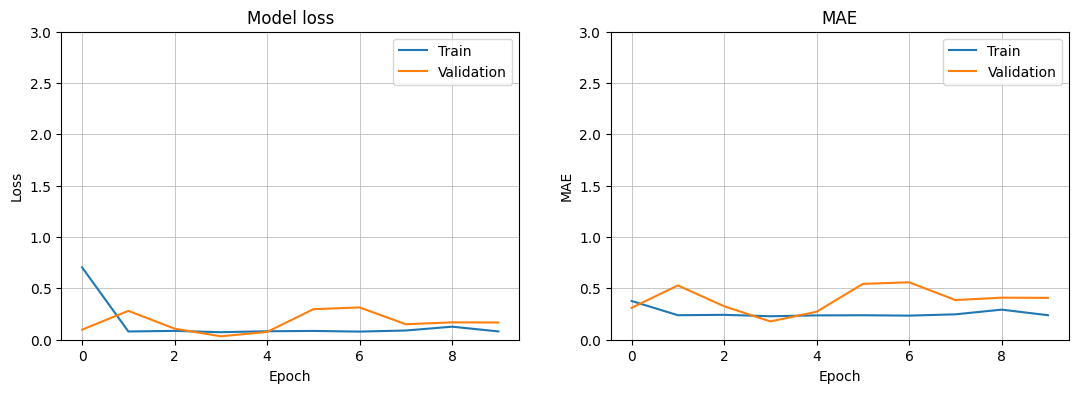

17/17 [==============================] - 0s 12ms/step - loss: 0.4519 - mae: 0.6637
MAE with epoch 100 --> 0.6637


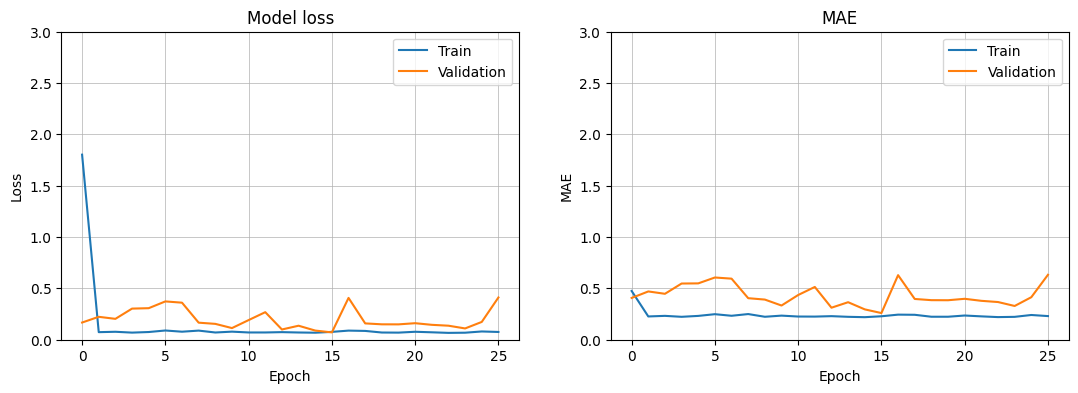

17/17 [==============================] - 0s 23ms/step - loss: 0.1862 - mae: 0.4301
MAE with epoch 500 --> 0.4301


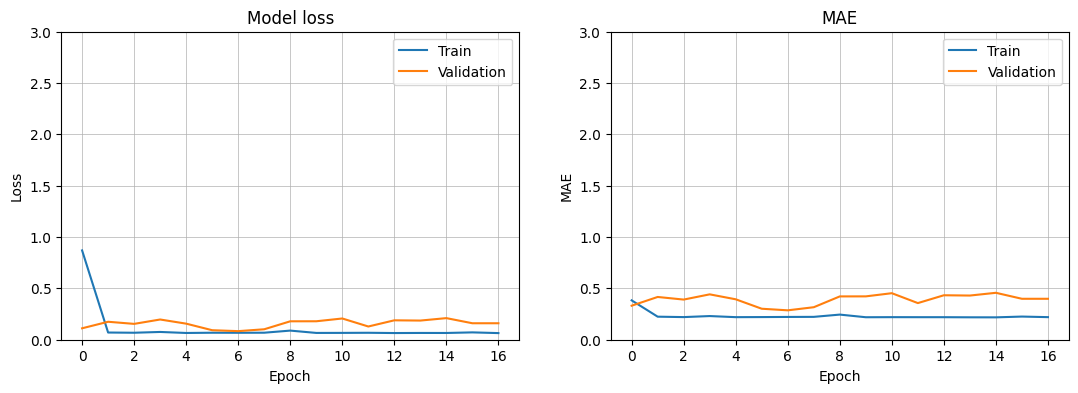

17/17 [==============================] - 0s 12ms/step - loss: 0.3155 - mae: 0.5601
MAE with epoch 1000 --> 0.5601


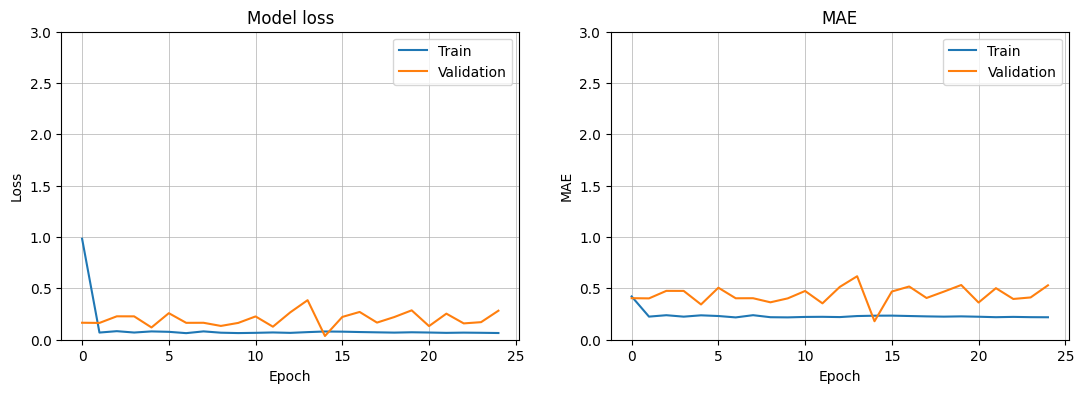

In [101]:
epochs = [10, 100, 500, 1000]


for epoch in epochs:
    # $CHALLENGIFY_BEGIN
    #getting the fresh data
    # x split
    X, y = window_data(df, best_window_size, feature_column, target_column)
    split = int(.7 * len(X))
    X_train = X[:split - 1]
    X_test = X[split:]

    # y split
    y_train = y[:split - 1]
    y_test = y[split:]
    #trying different scalers:
    scaler = best_scaler
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    scaler.fit(y_train)
    y_train = scaler.transform(y_train)
    y_test = scaler.transform(y_test)
    # Reshape the features for the model
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    # 1. Instantiating the Adam optimizer with a specific learning_rate
    adam = optimizers.Adam(learning_rate = best_learning_rate)
    # 2. Initializing the model
    model = init_model(X_train, y_train)
    # 3. Compiling the model with the custom Adam optimizer
    model = compile_model(model, adam)
    # 4. Training the neural net
    es = EarlyStopping(patience = 10)
    history = model.fit(X_train,
                        y_train,
                        validation_split = 0.3,
                        shuffle = True,
                        batch_size=16,
                        epochs = epoch,
                        callbacks = [es],
                        verbose = 0)
    # 5. Plot the history and evaluate the model
    res = model.evaluate(X_test, y_test)[1]
    results.append(res)
    print(f'MAE with epoch {epoch} --> {res:.4f}')
    plot_loss_mae(history)

In [107]:
best_epoch = 500

In [125]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics


def init_model2(X_train, y_train, activation):
    
    # $CHALLENGIFY_BEGIN    
    
    
    # 1 - RNN architecture
    # ======================    
    model = models.Sequential()

    ## 1.1 - Recurrent Layer
    model.add(layers.LSTM(64, 
                          activation='tanh', 
                          return_sequences = False,
                          recurrent_dropout = 0.2))
    #model.add(layers.LSTM(units=64, return_sequences=True, recurrent_dropout = 0.2))
    #model.add(layers.LSTM(units=64, return_sequences=True, recurrent_dropout = 0.2))
    ## 1.2 - Predictive Dense Layers
    output_length = y_train.shape[1]
    model.add(layers.Dense(output_length, activation=activation))


    
    return model
    # $CHALLENGIFY_END

In [126]:
def compile_model2(model, optimizer_name):
    # $CHALLENGIFY_BEGIN
    model.compile(loss = 'mse',
                  optimizer = optimizer_name,
                  metrics = ['mae'])
    return model

17/17 [==============================] - 0s 26ms/step - loss: 0.1549 - mae: 0.3920
MAE with activation tanh --> 0.3920


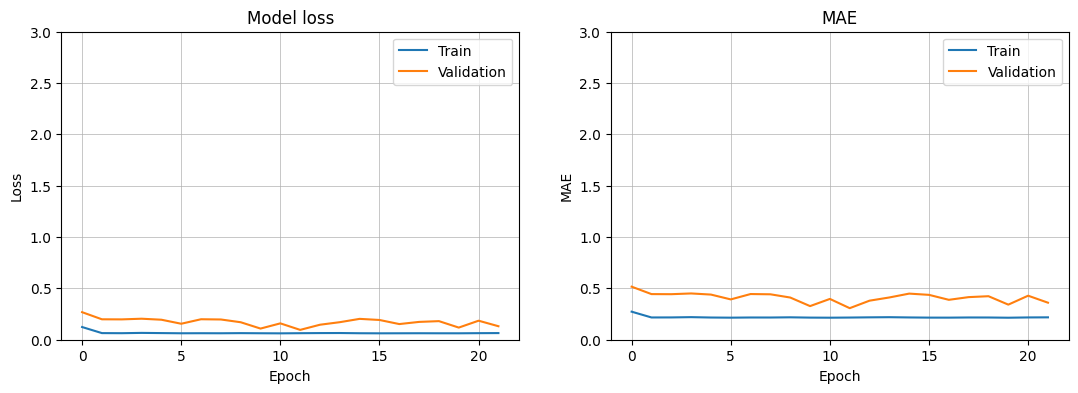

17/17 [==============================] - 0s 11ms/step - loss: 0.0038 - mae: 0.0513
MAE with activation relu --> 0.0513


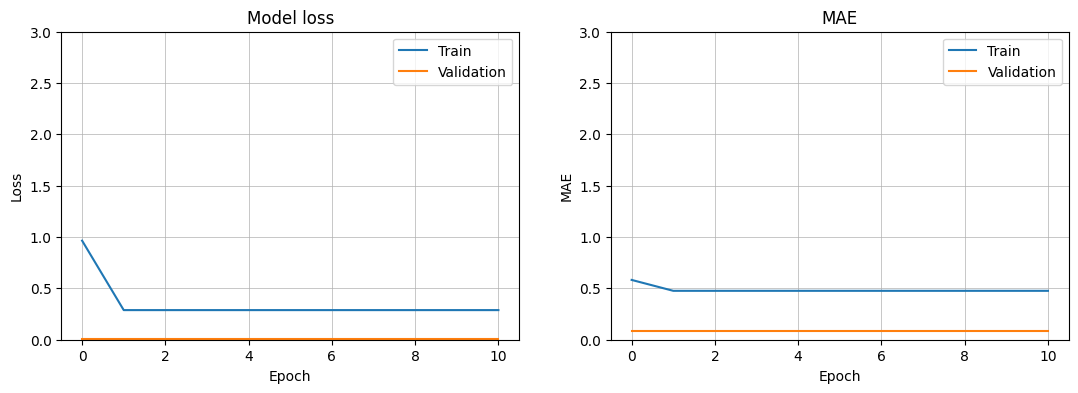

17/17 [==============================] - 0s 13ms/step - loss: 0.1460 - mae: 0.3804
MAE with activation elu --> 0.3804


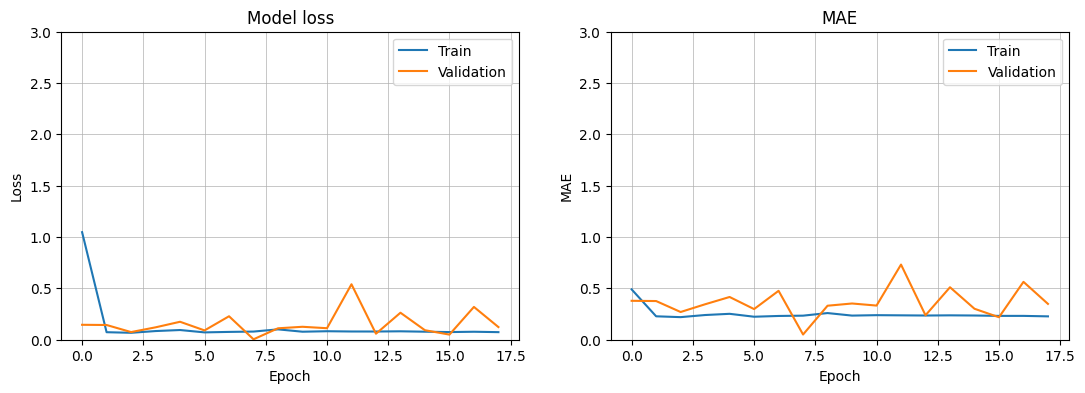

17/17 [==============================] - 0s 17ms/step - loss: 0.1619 - mae: 0.4008
MAE with activation selu --> 0.4008


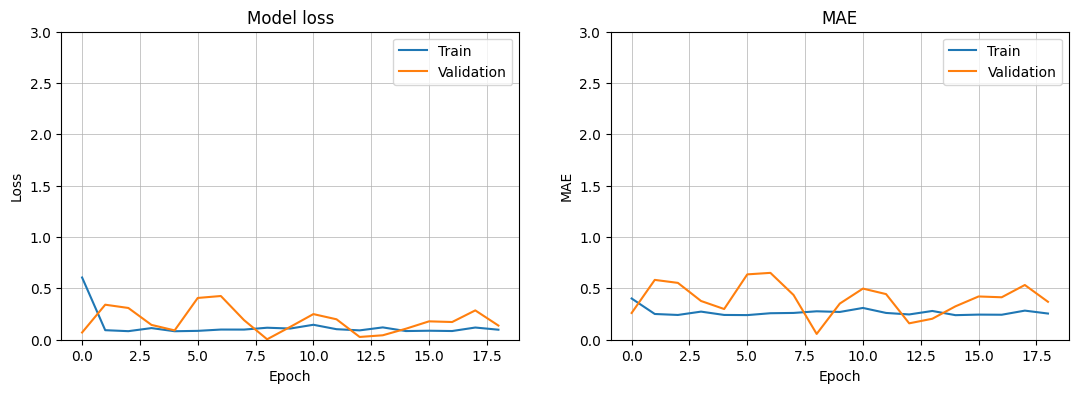

In [109]:
activation_functions = ['tanh', 'relu', 'elu', 'selu']


for activation in activation_functions:
    # $CHALLENGIFY_BEGIN
    #getting the fresh data
    # x split
    X, y = window_data(df, best_window_size, feature_column, target_column)
    split = int(.7 * len(X))
    X_train = X[:split - 1]
    X_test = X[split:]

    # y split
    y_train = y[:split - 1]
    y_test = y[split:]
    #trying different scalers:
    scaler = best_scaler
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    scaler.fit(y_train)
    y_train = scaler.transform(y_train)
    y_test = scaler.transform(y_test)
    # Reshape the features for the model
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    # 1. Instantiating the Adam optimizer with a specific learning_rate
    adam = optimizers.Adam(learning_rate = best_learning_rate)
    # 2. Initializing the model
    model = init_model2(X_train, y_train, activation)
    # 3. Compiling the model with the custom Adam optimizer
    model = compile_model2(model, adam)
    # 4. Training the neural net
    es = EarlyStopping(patience = 10)
    history = model.fit(X_train,
                        y_train,
                        validation_split = 0.3,
                        shuffle = True,
                        batch_size=16,
                        epochs = best_epoch,
                        callbacks = [es],
                        verbose = 0)
    # 5. Plot the history and evaluate the model
    res = model.evaluate(X_test, y_test)[1]
    results.append(res)
    print(f'MAE with activation {activation} --> {res:.4f}')
    plot_loss_mae(history)

In [110]:
best_activation = 'relu'

17/17 [==============================] - 2s 13ms/step - loss: 0.0038 - mae: 0.0513
MAE with batch size 1 --> 0.0513


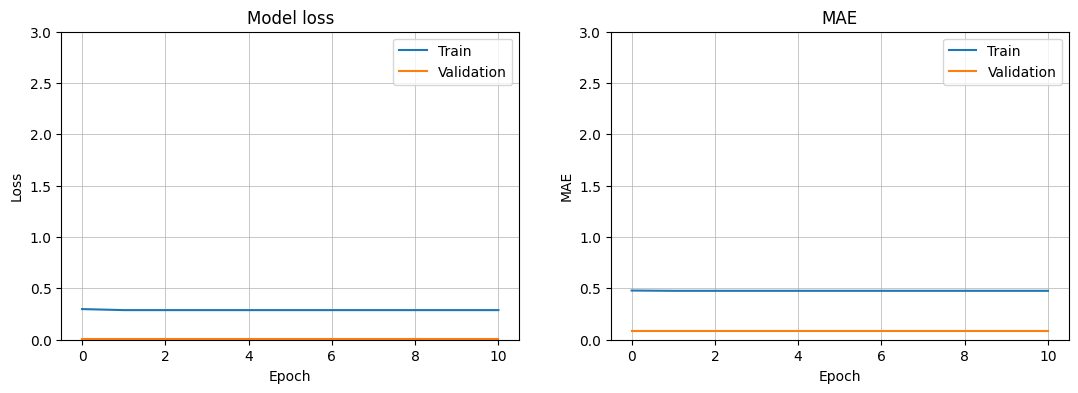

17/17 [==============================] - 1s 12ms/step - loss: 0.0038 - mae: 0.0513
MAE with batch size 4 --> 0.0513


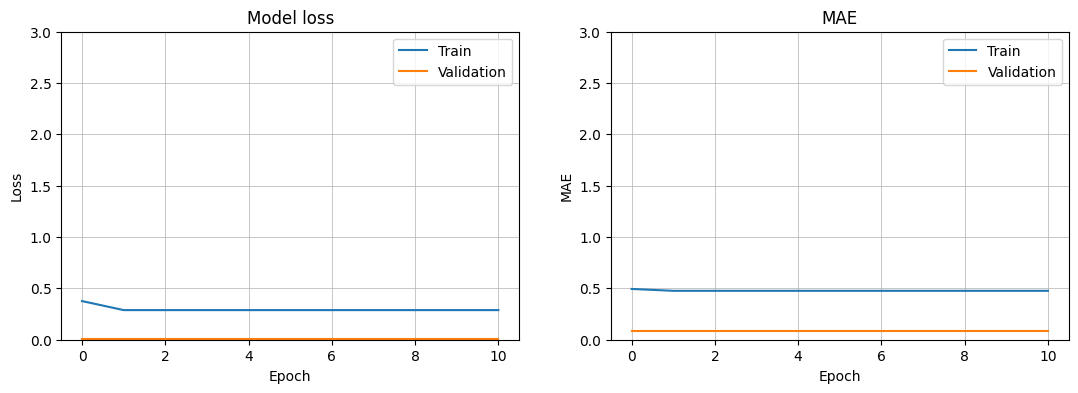

17/17 [==============================] - 0s 15ms/step - loss: 0.0038 - mae: 0.0513
MAE with batch size 8 --> 0.0513


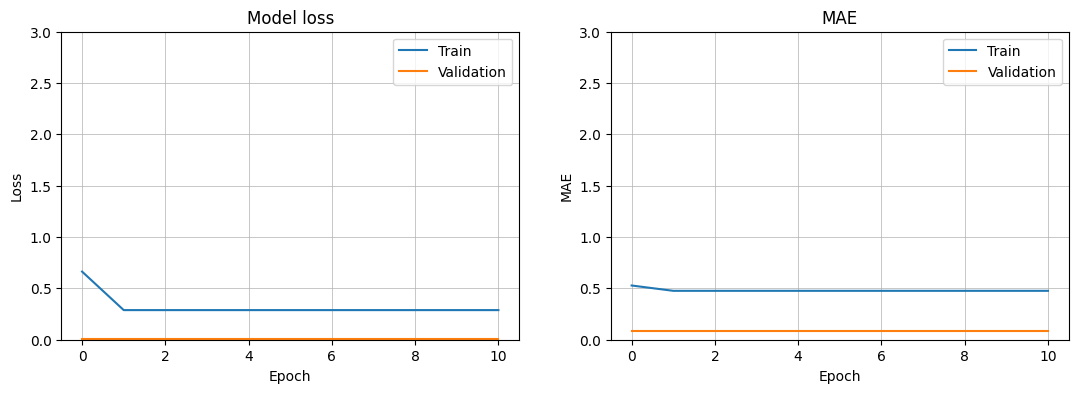

17/17 [==============================] - 0s 15ms/step - loss: 0.0038 - mae: 0.0513
MAE with batch size 16 --> 0.0513


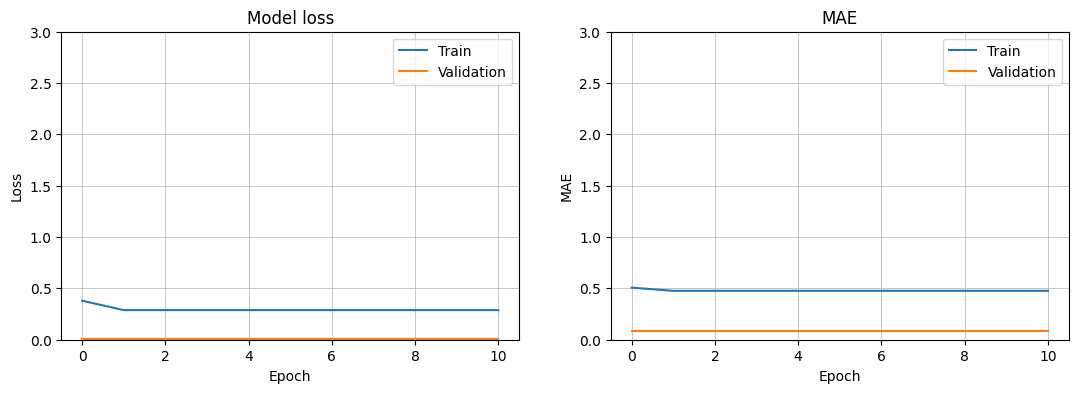

17/17 [==============================] - 0s 16ms/step - loss: 0.0038 - mae: 0.0513
MAE with batch size 32 --> 0.0513


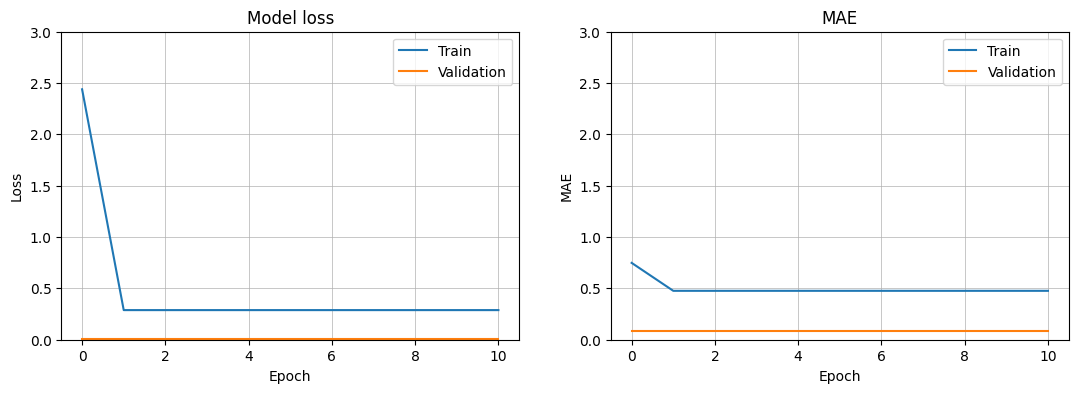

In [111]:
batch_sizes = [1, 4, 8, 16, 32]


for batch_size in batch_sizes:
    # $CHALLENGIFY_BEGIN
    #getting the fresh data
    # x split
    X, y = window_data(df, best_window_size, feature_column, target_column)
    split = int(.7 * len(X))
    X_train = X[:split - 1]
    X_test = X[split:]

    # y split
    y_train = y[:split - 1]
    y_test = y[split:]
    #trying different scalers:
    scaler = best_scaler
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    scaler.fit(y_train)
    y_train = scaler.transform(y_train)
    y_test = scaler.transform(y_test)
    # Reshape the features for the model
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    # 1. Instantiating the Adam optimizer with a specific learning_rate
    adam = optimizers.Adam(learning_rate = best_learning_rate)
    # 2. Initializing the model
    model = init_model2(X_train, y_train, best_activation)
    # 3. Compiling the model with the custom Adam optimizer
    model = compile_model2(model, adam)
    # 4. Training the neural net
    es = EarlyStopping(patience = 10)
    history = model.fit(X_train,
                        y_train,
                        validation_split = 0.3,
                        shuffle = False,
                        batch_size=batch_size,
                        epochs = best_epoch,
                        callbacks = [es],
                        verbose = 0)
    # 5. Plot the history and evaluate the model
    res = model.evaluate(X_test, y_test)[1]
    results.append(res)
    print(f'MAE with batch size {batch_size} --> {res:.4f}')
    plot_loss_mae(history)

In [135]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
import numpy as np

def window_data(df, window, feature__1_col_number, feature__2_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df[i:(i + window), [feature__1_col_number, feature__2_col_number]]
        #feature_2 = df.iloc[i:(i + window), feature__2_col_number]
        #[feature__1_col_number, feature__2_col_number]
        target = df[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [124]:
feature_1_column = 0
feature_2_column = 1
target_column = 1
window_size = 20
X, y = window_data(df, window_size, feature_1_column, feature_2_column, target_column)
print(X.shape, y.shape)

(1732, 20, 2) (1732, 1)


In [129]:
scaler.fit(df)
df = scaler.transform(df)

array([[0.26666667, 0.25043016],
       [0.22222222, 0.36308112],
       [0.23333333, 0.40015867],
       ...,
       [0.21111111, 0.05999533],
       [0.38888889, 0.12143509],
       [0.11111111, 0.08706478]])

17/17 [==============================] - 0s 11ms/step - loss: 0.0021 - mae: 0.0408
MAE with learning rate 0.0001 --> 0.0408


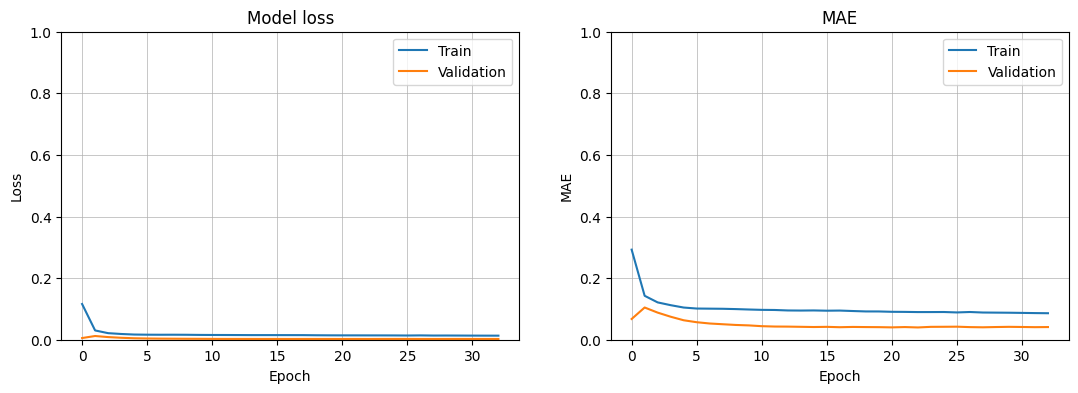

17/17 [==============================] - 0s 8ms/step - loss: 0.0049 - mae: 0.0638
MAE with learning rate 0.001 --> 0.0638


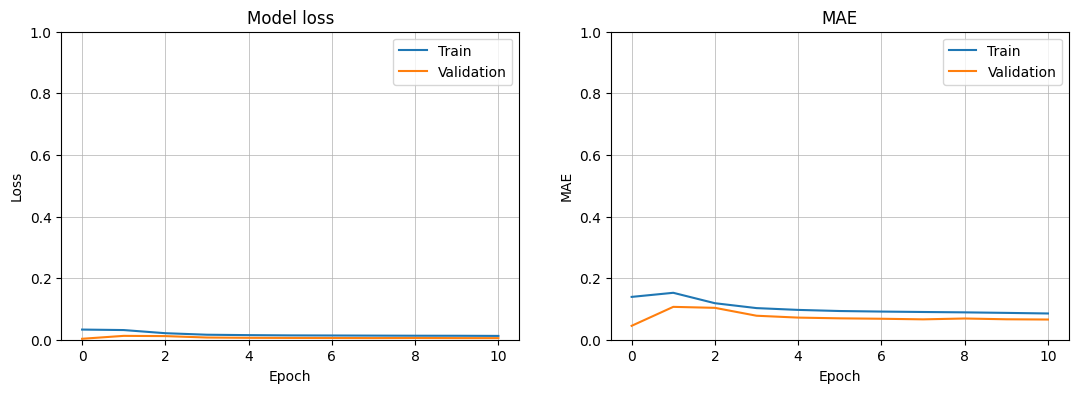

17/17 [==============================] - 0s 16ms/step - loss: 8.4506e-04 - mae: 0.0210
MAE with learning rate 0.01 --> 0.0210


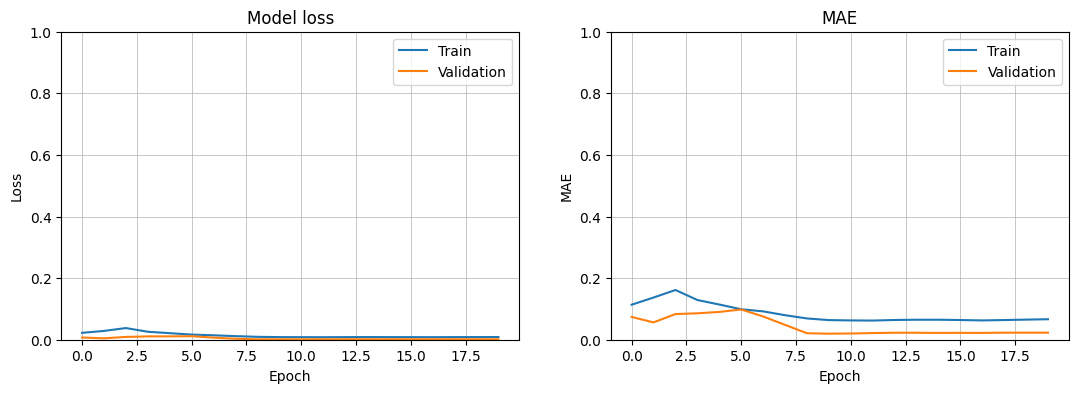

17/17 [==============================] - 0s 9ms/step - loss: 0.0045 - mae: 0.0569
MAE with learning rate 0.1 --> 0.0569


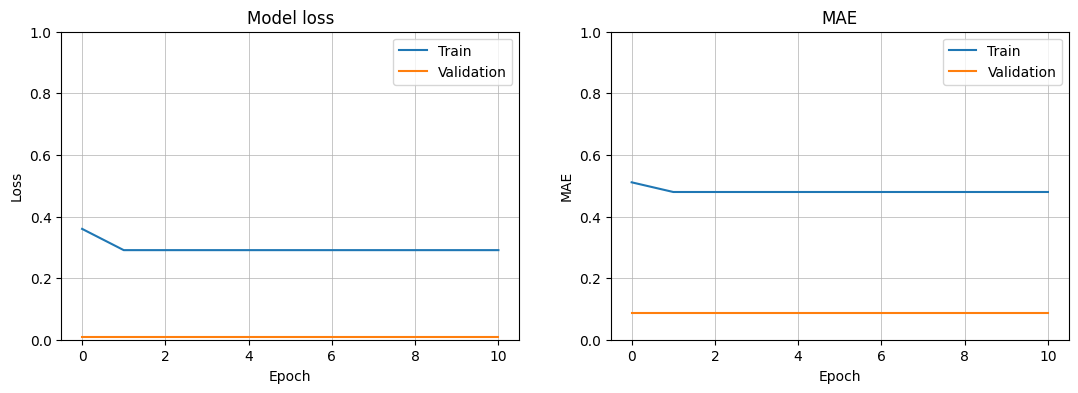

17/17 [==============================] - 0s 11ms/step - loss: 0.0045 - mae: 0.0569
MAE with learning rate 1 --> 0.0569


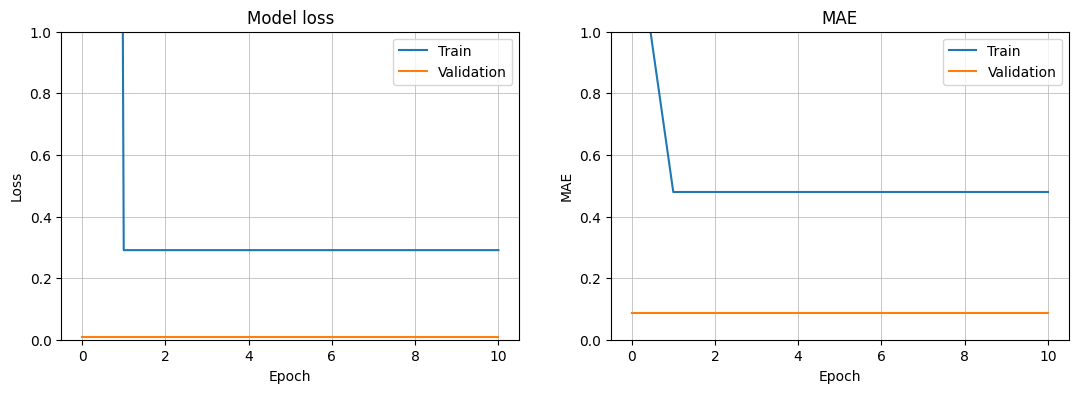

17/17 [==============================] - 0s 19ms/step - loss: 0.0045 - mae: 0.0569
MAE with learning rate 2 --> 0.0569


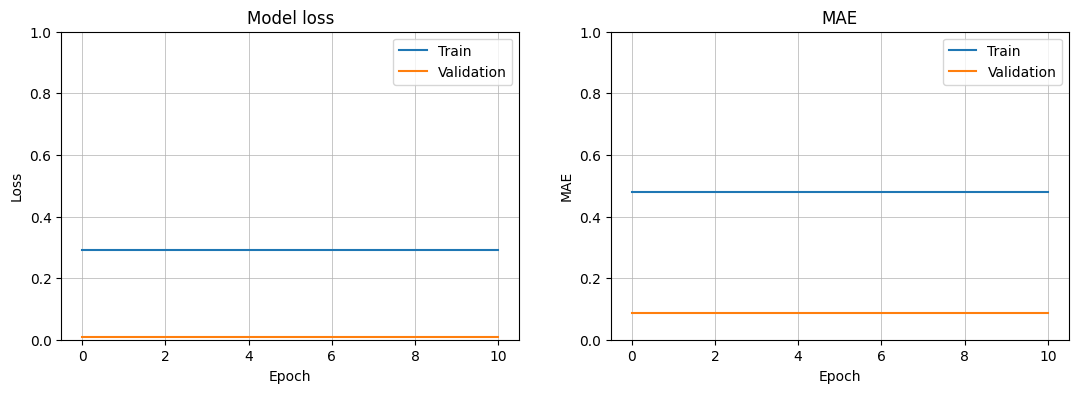

In [138]:
#adding the second feature
feature_1_column = 0
feature_2_column = 1
target_column = 1
window_size = 20
learning_rates = [0.0001, 0.001, 0.01, 0.1, 1, 2]

for learning_rate in learning_rates:
    # $CHALLENGIFY_BEGIN
    #getting the fresh data
    # x split
    scaler = best_scaler
    scaler.fit(df)
    df = scaler.transform(df)
    X, y = window_data(df, window_size, feature_1_column, feature_2_column, target_column)
    
    split = int(.7 * len(X))
    X_train = X[:split - 1]
    X_test = X[split:]

    # y split
    y_train = y[:split - 1]
    y_test = y[split:]

    # 1. Instantiating the Adam optimizer with a specific learning_rate
    adam = optimizers.Adam(learning_rate = learning_rate)
    # 2. Initializing the model
    model = init_model2(X_train, y_train, best_activation)
    # 3. Compiling the model with the custom Adam optimizer
    model = compile_model2(model, adam)
    # 4. Training the neural net
    es = EarlyStopping(patience = 10)
    history = model.fit(X_train,
                        y_train,
                        validation_split = 0.3,
                        shuffle = False,
                        batch_size=16,
                        epochs = best_epoch,
                        callbacks = [es],
                        verbose = 0)
    # 5. Plot the history and evaluate the model
    res = model.evaluate(X_test, y_test)[1]
    results.append(res)
    print(f'MAE with learning rate {learning_rate} --> {res:.4f}')
    plot_loss_mae(history)

In [140]:
best_learning_rate = 0.01 #this the new value, the loss is almost zero(0.0008)

17/17 [==============================] - 0s 6ms/step - loss: 6.7627e-04 - mae: 0.0201
MAE with window size 5 --> 0.0201


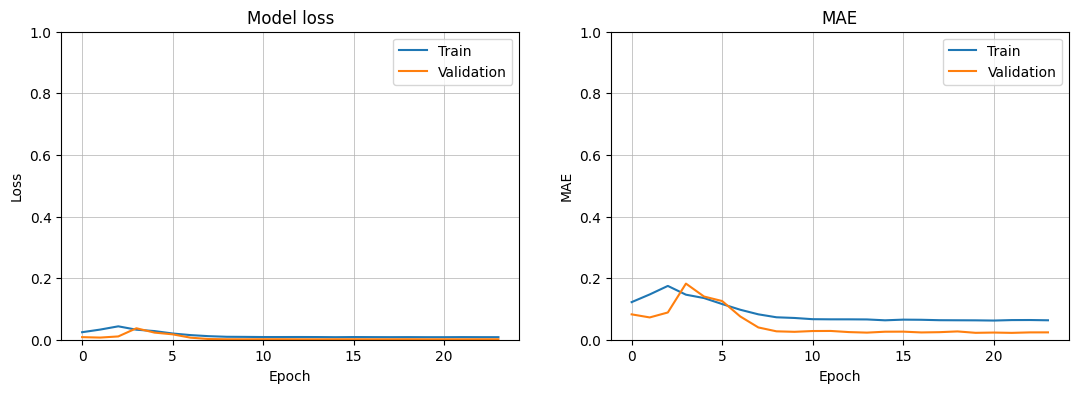

17/17 [==============================] - 0s 14ms/step - loss: 7.6502e-04 - mae: 0.0205
MAE with window size 10 --> 0.0205


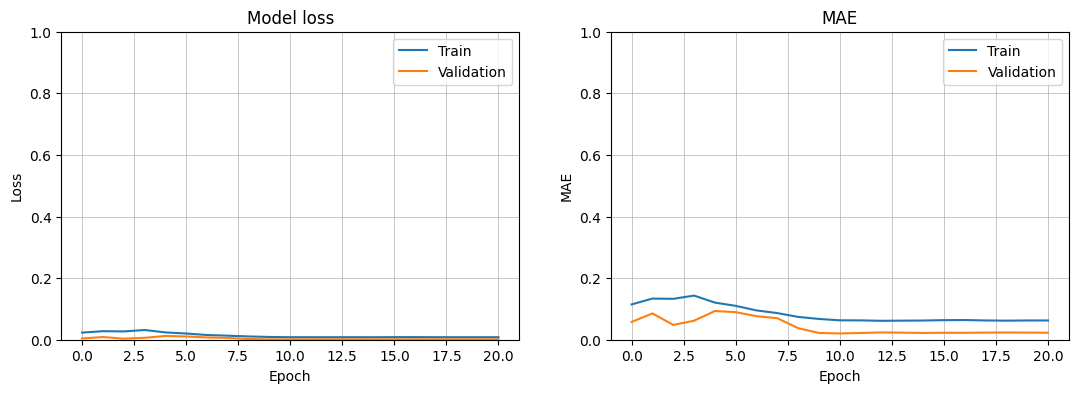

17/17 [==============================] - 0s 9ms/step - loss: 9.9485e-04 - mae: 0.0246
MAE with window size 20 --> 0.0246


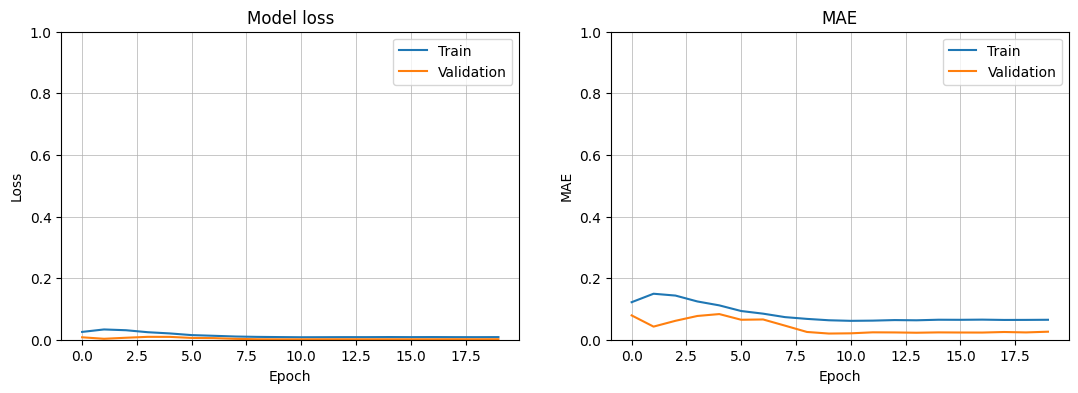

17/17 [==============================] - 0s 6ms/step - loss: 9.2430e-04 - mae: 0.0233
MAE with window size 30 --> 0.0233


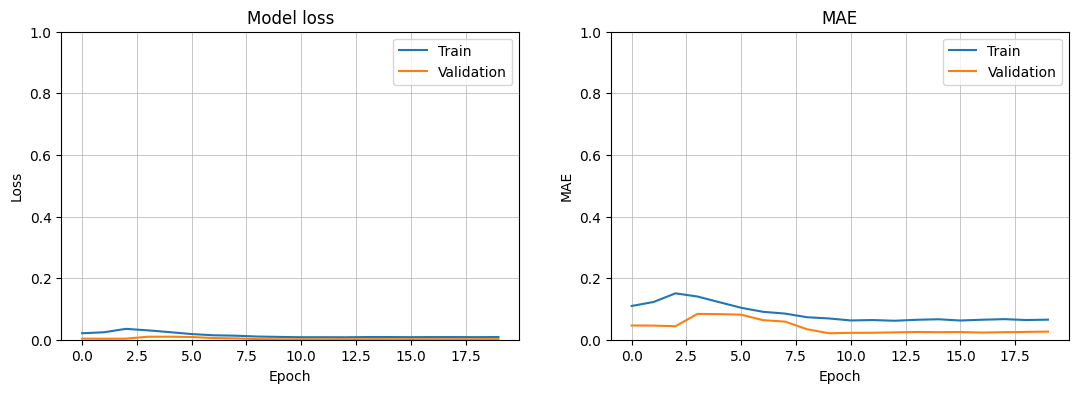

17/17 [==============================] - 0s 9ms/step - loss: 9.8169e-04 - mae: 0.0249
MAE with window size 40 --> 0.0249


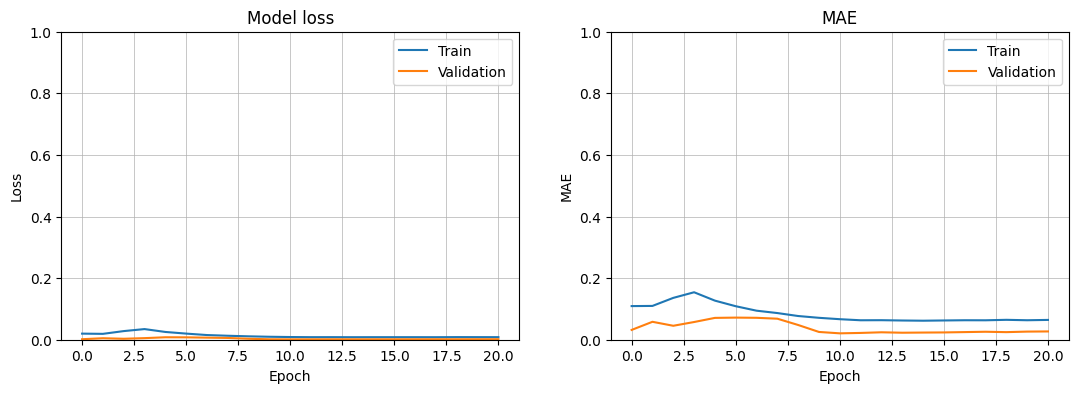

16/16 [==============================] - 0s 14ms/step - loss: 6.4621e-04 - mae: 0.0180
MAE with window size 50 --> 0.0180


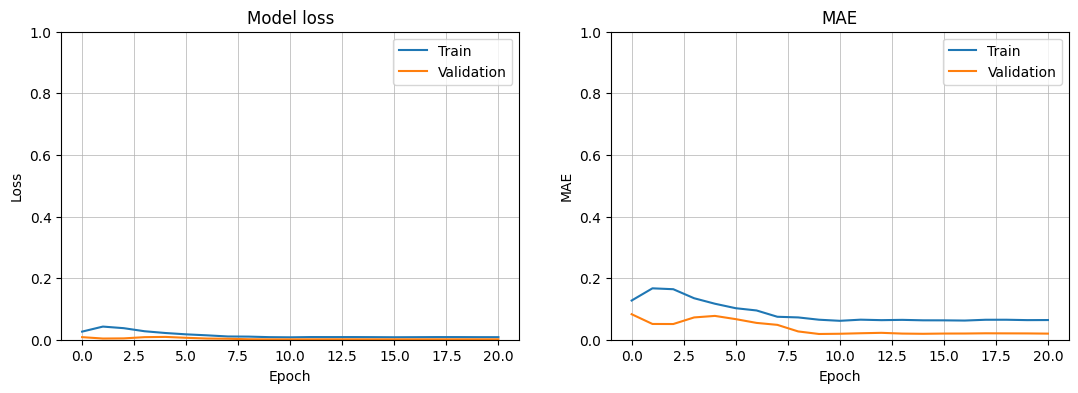

In [141]:
#adding the second feature
feature_1_column = 0
feature_2_column = 1
target_column = 1
window_size = 20
window_sizes = [5, 10, 20, 30, 40, 50]

for window_size in window_sizes:
    # $CHALLENGIFY_BEGIN
    #getting the fresh data
    # x split
    scaler = best_scaler
    scaler.fit(df)
    df = scaler.transform(df)
    X, y = window_data(df, window_size, feature_1_column, feature_2_column, target_column)
    
    split = int(.7 * len(X))
    X_train = X[:split - 1]
    X_test = X[split:]

    # y split
    y_train = y[:split - 1]
    y_test = y[split:]

    # 1. Instantiating the Adam optimizer with a specific learning_rate
    adam = optimizers.Adam(learning_rate = best_learning_rate)
    # 2. Initializing the model
    model = init_model2(X_train, y_train, best_activation)
    # 3. Compiling the model with the custom Adam optimizer
    model = compile_model2(model, adam)
    # 4. Training the neural net
    es = EarlyStopping(patience = 10)
    history = model.fit(X_train,
                        y_train,
                        validation_split = 0.3,
                        shuffle = False,
                        batch_size=16,
                        epochs = best_epoch,
                        callbacks = [es],
                        verbose = 0)
    # 5. Plot the history and evaluate the model
    res = model.evaluate(X_test, y_test)[1]
    results.append(res)
    print(f'MAE with window size {window_size} --> {res:.4f}')
    plot_loss_mae(history)

In [142]:
best_window_size = 20

17/17 [==============================] - 0s 6ms/step - loss: 6.6626e-04 - mae: 0.0185
MAE with epoch 10 --> 0.0185


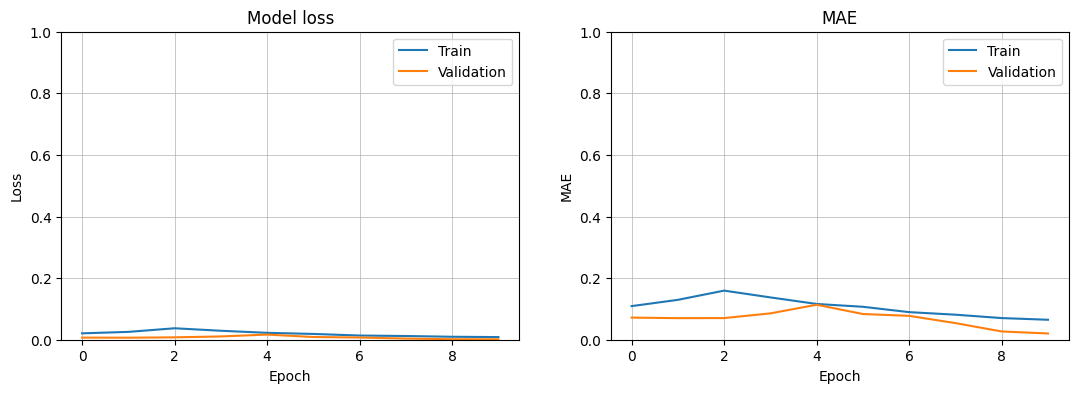

17/17 [==============================] - 0s 6ms/step - loss: 0.0045 - mae: 0.0569
MAE with epoch 50 --> 0.0569


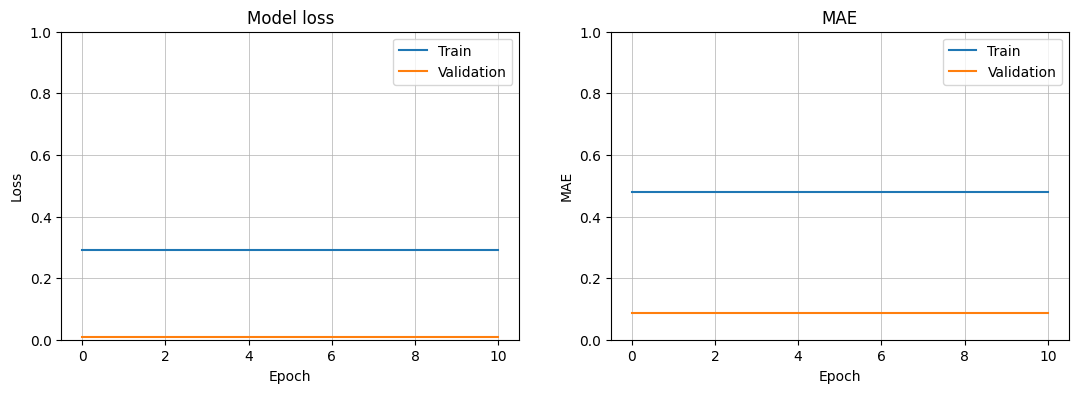

17/17 [==============================] - 0s 9ms/step - loss: 9.1172e-04 - mae: 0.0226
MAE with epoch 100 --> 0.0226


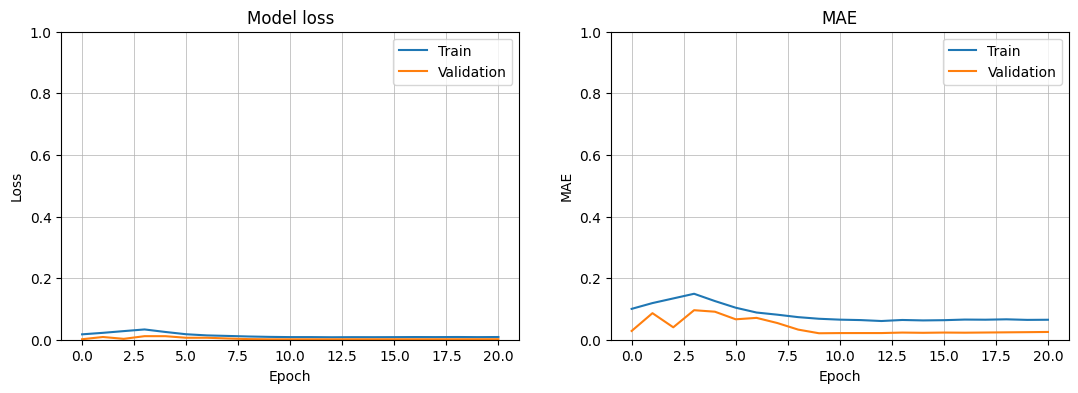

17/17 [==============================] - 0s 12ms/step - loss: 0.0010 - mae: 0.0237
MAE with epoch 500 --> 0.0237


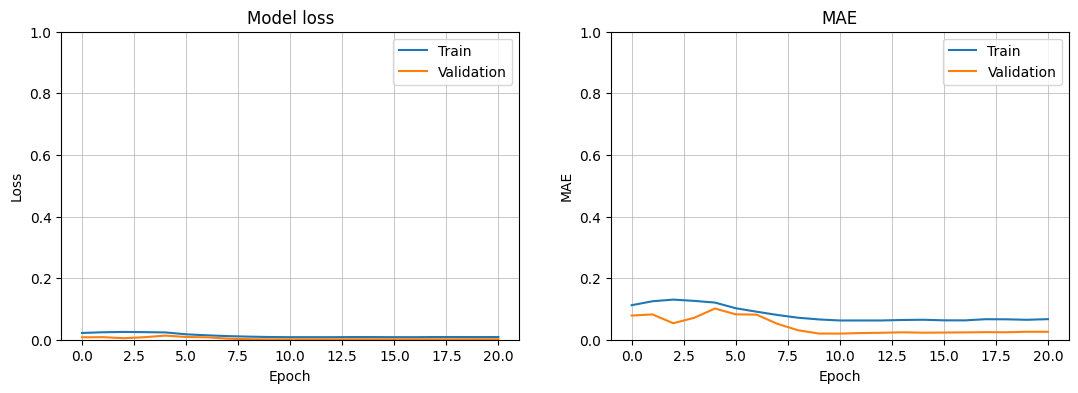

In [144]:
#adding the second feature
feature_1_column = 0
feature_2_column = 1
target_column = 1
window_size = 20
epochs = [10, 50, 100, 500]

for epoch in epochs:
    # $CHALLENGIFY_BEGIN
    #getting the fresh data
    # x split
    scaler = best_scaler
    scaler.fit(df)
    df = scaler.transform(df)
    X, y = window_data(df, window_size, feature_1_column, feature_2_column, target_column)
    
    split = int(.7 * len(X))
    X_train = X[:split - 1]
    X_test = X[split:]

    # y split
    y_train = y[:split - 1]
    y_test = y[split:]

    # 1. Instantiating the Adam optimizer with a specific learning_rate
    adam = optimizers.Adam(learning_rate = best_learning_rate)
    # 2. Initializing the model
    model = init_model2(X_train, y_train, best_activation)
    # 3. Compiling the model with the custom Adam optimizer
    model = compile_model2(model, adam)
    # 4. Training the neural net
    es = EarlyStopping(patience = 10)
    history = model.fit(X_train,
                        y_train,
                        validation_split = 0.3,
                        shuffle = False,
                        batch_size=16,
                        epochs = epoch,
                        callbacks = [es],
                        verbose = 0)
    # 5. Plot the history and evaluate the model
    res = model.evaluate(X_test, y_test)[1]
    results.append(res)
    print(f'MAE with epoch {epoch} --> {res:.4f}')
    plot_loss_mae(history)